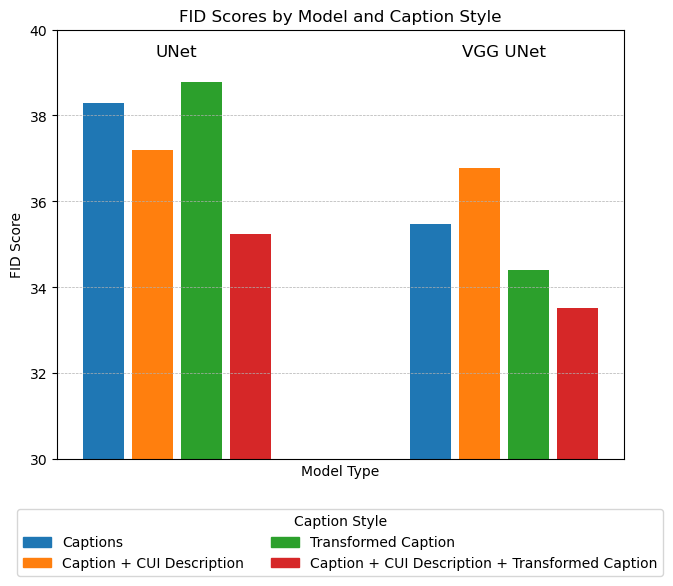

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    'Model': ['UNet', 'UNet', 'UNet', 'UNet', 'VGG UNet', 'VGG UNet', 'VGG UNet', 'VGG UNet'],
    'Caption Style': ['Captions', 'Caption + CUI Description', 'Transformed Caption', 'Caption + CUI Description + Transformed Caption',
                      'Captions', 'Caption + CUI Description', 'Transformed Caption', 'Caption + CUI Description + Transformed Caption'],
    'FID': [38.2849, 37.2050, 38.7760, 35.2501, 35.4735, 36.7792, 34.4119, 33.5230]
}

# Create DataFrame
df = pd.DataFrame(data)

# Define colors for caption styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
caption_styles = ['Captions', 'Caption + CUI Description', 'Transformed Caption', 'Caption + CUI Description + Transformed Caption']

# Plot settings
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.5  # Width of the bars

# Define positions for the bars
x_unet = np.array([0, 0.6, 1.2, 1.8])
x_vgg_unet = np.array([4, 4.6, 5.2, 5.8])

# Plot bars for UNet model
for i, style in enumerate(caption_styles):
    ax.bar(x_unet[i], df[(df['Model'] == 'UNet') & (df['Caption Style'] == style)]['FID'], 
           width, color=colors[i], label=style if i == 0 else "")

# Plot bars for VGG UNet model
for i, style in enumerate(caption_styles):
    ax.bar(x_vgg_unet[i], df[(df['Model'] == 'VGG UNet') & (df['Caption Style'] == style)]['FID'], 
           width, color=colors[i])

# Set y-axis limit
ax.set_ylim(30, 40)

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add titles and labels
ax.set_xlabel('Model Type')
ax.set_ylabel('FID Score')
ax.set_title('FID Scores by Model and Caption Style')

# Remove x-axis labels
ax.set_xticks([])
ax.set_xticklabels([])

# Add text labels to indicate the groups
for x, label in zip([x_unet.mean(), x_vgg_unet.mean()], ['UNet', 'VGG UNet']):
    ax.text(x, 39.3, label, ha='center', va='bottom', fontsize=12)

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(handles, caption_styles, title='Caption Style', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

# Show plot
plt.tight_layout()
plt.savefig('../fig/fid_scores.png')
# plt.show()



---

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [59]:
DATA_PATH = "../data/rocov2"

In [60]:
df = pd.read_csv(os.path.join(DATA_PATH, "processed", "train_top10_kcf.csv"))
df.head()

,ID,Caption,CUIs,CUI_caption,keywords
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography,"X-ray, Parotid gland, Side view, Left parotitis."
1,ROCOv2_2023_train_000006,5.1 cm x 3.4 cm x 4 cm multiloculated hepatic ...,C0040405,X-Ray Computed Tomography,"X-ray, Liver, Side, Multiloculated abscess."
2,ROCOv2_2023_train_000010,Preop CT showing left orbital floor fracture,C0040405,X-Ray Computed Tomography,"X-ray, Orbit, Floor of Orbit from below, Fract..."
3,ROCOv2_2023_train_000011,Postop 22-month CT scan (sagittal): Posteriorl...,C0040405,X-Ray Computed Tomography,"X-ray, Spine, Sagittal View, Normal."
4,ROCOv2_2023_train_000015,CT demonstrating partially obstructed airway.C...,C0040405,X-Ray Computed Tomography,"Computed Tomography, Airway, Oblique View of, ..."


In [61]:
config = AutoConfig.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
tokenizer = AutoTokenizer.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
radbert = AutoModel.from_pretrained('zzxslp/RadBERT-RoBERTa-4m', config=config)

Some weights of RobertaModel were not initialized from the model checkpoint at zzxslp/RadBERT-RoBERTa-4m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
bert_res = []
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating BERT output"):
    caption = row["Caption"] + " " + row["keywords"]
    # caption = row["keywords"]
    inputs = tokenizer(caption, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
    outputs = radbert(**inputs)
    bert_res.append(outputs.last_hidden_state[:, 0, :].detach().numpy())

df["radbert_output"] = bert_res

Generating BERT output:   0%|          | 0/6490 [00:00<?, ?it/s]

In [63]:
df.head()

,ID,Caption,CUIs,CUI_caption,keywords,radbert_output
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography,"X-ray, Parotid gland, Side view, Left parotitis.","[[-0.022309985, 0.1292526, -0.02261541, -0.066..."
1,ROCOv2_2023_train_000006,5.1 cm x 3.4 cm x 4 cm multiloculated hepatic ...,C0040405,X-Ray Computed Tomography,"X-ray, Liver, Side, Multiloculated abscess.","[[0.030758752, 0.055539645, -0.083258465, -0.0..."
2,ROCOv2_2023_train_000010,Preop CT showing left orbital floor fracture,C0040405,X-Ray Computed Tomography,"X-ray, Orbit, Floor of Orbit from below, Fract...","[[-0.011818331, 0.06305252, -0.08188978, -0.10..."
3,ROCOv2_2023_train_000011,Postop 22-month CT scan (sagittal): Posteriorl...,C0040405,X-Ray Computed Tomography,"X-ray, Spine, Sagittal View, Normal.","[[0.031070622, 0.10399916, -0.047960926, -0.02..."
4,ROCOv2_2023_train_000015,CT demonstrating partially obstructed airway.C...,C0040405,X-Ray Computed Tomography,"Computed Tomography, Airway, Oblique View of, ...","[[0.0006374121, 0.14555964, -0.065620854, -0.0..."


In [64]:
tsne = TSNE(n_components=2)
X = df["radbert_output"].apply(lambda x: x[0])
X = np.array(X.to_list())
X_embedded = tsne.fit_transform(X)

In [65]:
X_embedded

array([[ 31.881735 , -44.5524   ],
       [ 14.744698 ,  16.352337 ],
       [ -1.7647369, -31.66718  ],
       ...,
       [ -6.042418 , -27.724728 ],
       [ -5.980555 , -65.31531  ],
       [-23.09991  , -63.287273 ]], dtype=float32)

In [66]:
min_x = min(X_embedded[:,0])
max_x = max(X_embedded[:,0])

min_y = min(X_embedded[:,1])
max_y = max(X_embedded[:,1])

print(min_x, max_x)
print(min_y, max_y)

-78.27432 66.08749
-72.41608 62.6613


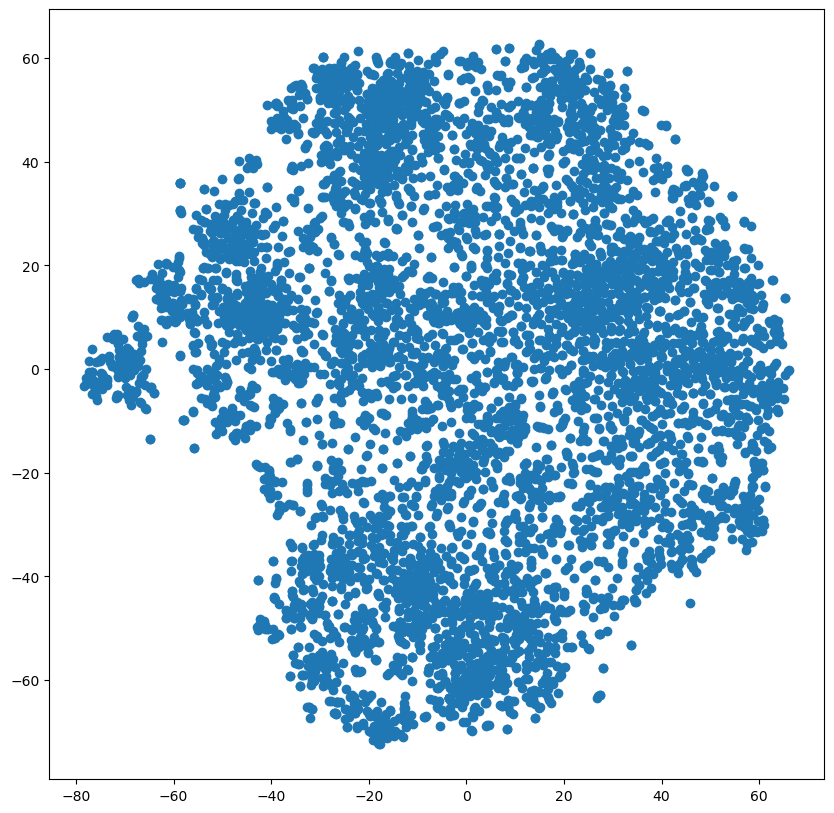

In [67]:
#plot the tsne with clusters having different colors. enclose the clusters in an oval and write the cluster number
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])#, c=df["cluster"], cmap="viridis")
# for i in range(5):
    # cluster = X_embedded[df["cluster"] == i]
    # x, y = cluster[:, 0], cluster[:, 1]
    # x_mean, y_mean = np.mean(x), np.mean(y)
    # plt.text(x_mean, y_mean, str(i), fontsize=12)
    # plt.gca().add_artist(plt.Circle((x_mean, y_mean), 0.5, fill=False, color="red"))
plt.savefig("../fig/cluster_cap_keywords.png")